<h4>I. Các thư viện và model được sử dụng</h4>

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.context import SparkContext

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr

import pyspark.ml as ml
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np

ModuleNotFoundError: ignored

In [ ]:
# Create a Spark Session
spark = spark = (SparkSession
         .builder
         .appName("Predicting Flight Delay")
         .getOrCreate())
# Check Spark Session Information
spark

In [ ]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[*] appName=Predicting Flight Delay>

In [ ]:
sqlContext = SQLContext(sc)

d:\HocMay_BigData\my_env_1\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Load file csv lên bằng pyspark

In [ ]:
df = sqlContext.read.format(
    "csv").option("header", "true").load("./data/Combined_Flights_2018.csv",
    inferSchema=True)

Lấy ra 40.000 dòng để phân tích

In [ ]:
df_40000 = df.limit(40000)
df_40000_new = df_40000.filter((df_40000.Cancelled == 0)&(df_40000.Diverted == 0))
df_40000_new.count()

38954



Delayed - Chuyến bay có độ trễ đến lớn hơn hoặc bằng 15 phút



In [ ]:
df_40000_new = df_40000_new.withColumn('Delayed', (df_40000_new.ArrDelay >= 15).cast('int'))

TimeSlot được tạo ra để phân loại chuyến bay vào các khoảng thời gian khác nhau trong ngày dựa trên giờ khởi hành dự kiến (CRSDepTime)

In [ ]:
sqlContext.registerDataFrameAsTable(df_40000_new, "df_40000_new")

df_40000_new_1 = sqlContext.sql("select *, case \
               when CRSDepTime <= 800 then 1 \
               when 800 < CRSDepTime and CRSDepTime <= 1200 then 2 \
               when 1200 < CRSDepTime and CRSDepTime <= 1600 then 3 \
               when 1600 < CRSDepTime and CRSDepTime <= 2100 then 4 \
               else 1 end as TimeSlot \
               from df_40000_new")

In [ ]:
indexer = StringIndexer(inputCol='Marketing_Airline_Network',outputCol='IndexUniqueCarrier')

In [ ]:
df_40000_new_2 = indexer.fit(df_40000_new_1).transform(df_40000_new_1)

In [ ]:
df_40000_new_2.groupBy('Marketing_Airline_Network','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()

+-------------------------+------------------+-----+
|Marketing_Airline_Network|IndexUniqueCarrier|count|
+-------------------------+------------------+-----+
|                       DL|               0.0|12708|
|                       HA|               1.0| 7485|
|                       NK|               2.0| 6286|
|                       B6|               3.0| 5464|
|                       UA|               4.0| 3507|
|                       G4|               5.0| 2437|
|                       AS|               6.0|  684|
|                       F9|               7.0|  383|
+-------------------------+------------------+-----+



In [ ]:
df_40000_new_2.describe().show()

+-------+----------------+------+-----+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------+-------+-----+------------------+------------------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+------------------+------------------+------------------+--------------+-----------+------------------+---------------+------------------+------------------+------------------+------------------+-------------+---------+-----------------+-------------+------------------+------------------+--------------------+----------+------------------+-----------------+------------------+------------------+------------------+------------------+----------------

Sử dụng hồi quy tuyến tính để giải quyết các câu hỏi đặt ra:

Phân tích mối quan hệ giữa thời gian bay (AirTime) và khoảng cách (Distance)

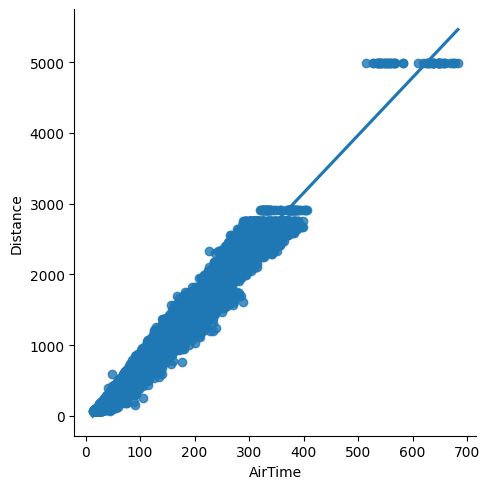

In [ ]:
# Select the relevant columns for the scatterplot
cols = ["AirTime", "Distance"]

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_40000_new_2.select(cols).toPandas()

# Create scatterplot with linear regression line
sns.lmplot(x="AirTime", y="Distance", data=df_pandas)

# Show the plot
plt.show()

 Phân tích mối quan hệ giữa hai biến "ArrDelay" (Độ trễ khi đến) và "DepDelay" (Độ trễ khi khởi hành)

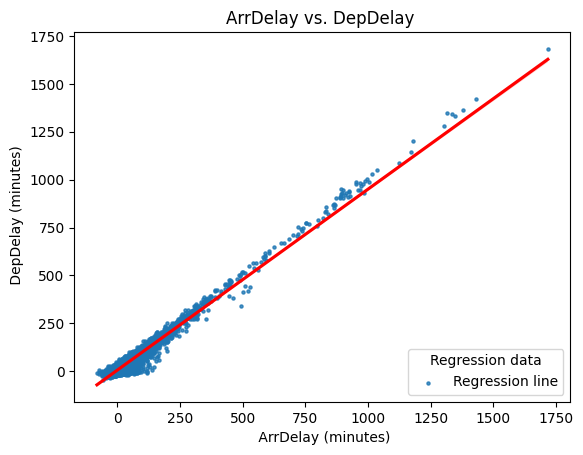

In [ ]:
# Create a scatter plot with a regression line
sns.regplot(x=df_40000_new_2.select("ArrDelay").toPandas(),
            y=df_40000_new_2.select("DepDelay").toPandas(),
            scatter_kws={"s": 5}, line_kws={"color": "red"}, label="Regression line")


# Set plot title and axis labels
plt.title("ArrDelay vs. DepDelay ")
plt.xlabel(" ArrDelay (minutes)")
plt.ylabel(" DepDelay (minutes)")

# Show the legend with the regression data
plt.legend(title="Regression data", loc="lower right")

# Show the plot
plt.show()

Sau khi ta thấy độ trễ khi khởi hành so với độ trễ khi đến là khá cao cho thấy độ trễ chuyến bay hầu như đều do độ trễ khi chuyến bay đó bắt đầu khởi hành vậy sẽ kiểm tra tần suất mà độ trễ khơi hành ảnh hưởng tới chuyến bay

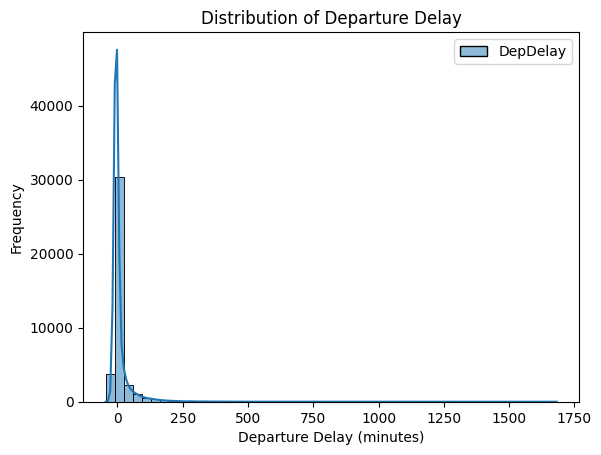

In [ ]:
# Select the "DepDelay" column and convert to Pandas
dep_delay = df_40000_new_2.select("DepDelay").toPandas()

# Plot the histogram using Seaborn
sns.histplot(dep_delay, bins=50, kde=True)

# Set plot title and axis labels
plt.title("Distribution of Departure Delay")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")

# Show the plot
plt.show()